In [26]:
import requests
import pandas as pd
from functools import reduce
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [13]:
class DomIdLoader:
    def __init__(self, limit_per_req=250):
        self.limit_ = limit_per_req

        self.url_total = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?sortField=objId&sortType=asc&objStatus=0'
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'
        self.total_objects = requests.get(self.url_total).json().get('data').get('total')

        self.objects_data = []

    def get_ids(self):
        num_response = (self.total_objects + self.limit_ - 1) // self.limit_
        for i in tqdm(range(num_response)):
            offset = i * self.limit_
            config = {
                'offset': offset,
                'limit': self.limit_,
                'sortField': 'objId',
                'sortType': 'asc',
                'objStatus': '0'
            }

            res = requests.get(self.url, params=config).json().get('data').get('list')

            obj_Ids = [x.get('objId') for x in res]
            self.objects_data.append(obj_Ids)

        self.objects_data = reduce(lambda x, y: x + y, self.objects_data)
        print(f'Загружено objId: {len(self.objects_data)} из {self.total_objects}')

    def show_ids(self):
        return self.objects_data

In [15]:
class ObjectInfoExtractor:
    def __init__(self, ids):
        self.obj_Ids = ids
        self.cnt_errors = 0
        self.downloading_data = []
        self.pandas_data = None

    def load_data(self):
        for objId in tqdm(self.obj_Ids):
            try:
                url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{objId}'
                obj_data = requests.get(url).json().get('data')
            except:
                self.cnt_errors += 1
            else:
                self.downloading_data.append(obj_data)

        print(f"Ошибок во время загрузки данных: {self.cnt_errors}\n"
              f"Всего удалось скачать данных: {len(self.downloading_data)} из {len(self.obj_Ids)}")

    def df_converter(self):
        self.pandas_data = pd.json_normalize(self.downloading_data)

In [24]:
class Saver:
    def __init__(self, data):
        self.data = data

    def save_csv(self, name):
        self.data.to_csv(f"{name}.csv")

    def save_excel(self, name):
        self.data.to_excel(f"{name}.xlsx")

    def save_sql(self, db, name):
        conn = sqlite3.connect(f'{db}')
        self.data.to_sql(name, conn, if_exists='replace', index=False)

In [33]:
class Visualizer:
    def __init__(self, data):
        self.data = data

    def make_boxplot(self, x, y, title, title_size=14):
        plt.figure(figsize=(18, 8))
        sns.boxplot(data=self.data,
                    x=x,
                    y=y)
        plt.title(title, size=title_size)

    def make_barplot(self, x, y, estimator, title, title_size=14):
        plt.figure(figsize=(18, 8))
        sns.barplot(data=self.data,
                    x=x,
                    y=y,
                    estimator=estimator)
        plt.title(title, size=title_size)

In [18]:
ids_downloader = DomIdLoader(limit_per_req=500)
ids_downloader.get_ids()

  0%|          | 0/22 [00:00<?, ?it/s]

Загружено objId: 10660 из 10660


In [19]:
dataset = ObjectInfoExtractor(ids_downloader.show_ids())
dataset.load_data()

  0%|          | 0/10660 [00:00<?, ?it/s]

Ошибок во время загрузки данных: 3
Всего удалось скачать данных: 10657 из 10660


In [21]:
dataset.df_converter()

In [23]:
dataset.pandas_data.head()

,id,pdId,region,address,nameObj,floorMin,floorMax,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,...,developer.bankruptStage.bankruptStageDesc,developer.bankruptStage.bankruptLawUrl,developer.orgBankruptMsgDttm,metro.id,metro.name,metro.line,metro.color,metro.time,metro.isWalk,metro.colors
0,1259,1320,62,"г Рязань, улица Бугровка, д. 0","""СМАРТ дом на Новоселов""",27.0,27.0,440,2023-12-31,Монолит-кирпич,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1284,1527,77,"г Москва, район внутригородское муниципальное ...","Жилой Комплекс ""Мир Митино"" (сокращенное наиме...",27.0,27.0,1115,2024-12-31,Блоки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1366,1474,23,"г Краснодар, улица им. Героя Яцкова И.В., лите...","Микрорайон ""Губернский""",25.0,25.0,207,2025-06-30,Монолит-кирпич,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1367,1474,23,"г Краснодар, улица им. Героя Яцкова И.В., лите...","Микрорайон ""Губернский""",1.0,1.0,0,2025-06-30,Монолит-кирпич,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1368,1476,23,"г Краснодар, улица им. Героя Яцкова И.В., лите...","Микрорайон ""Губернский""",1.0,19.0,321,2025-06-30,Монолит-кирпич,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


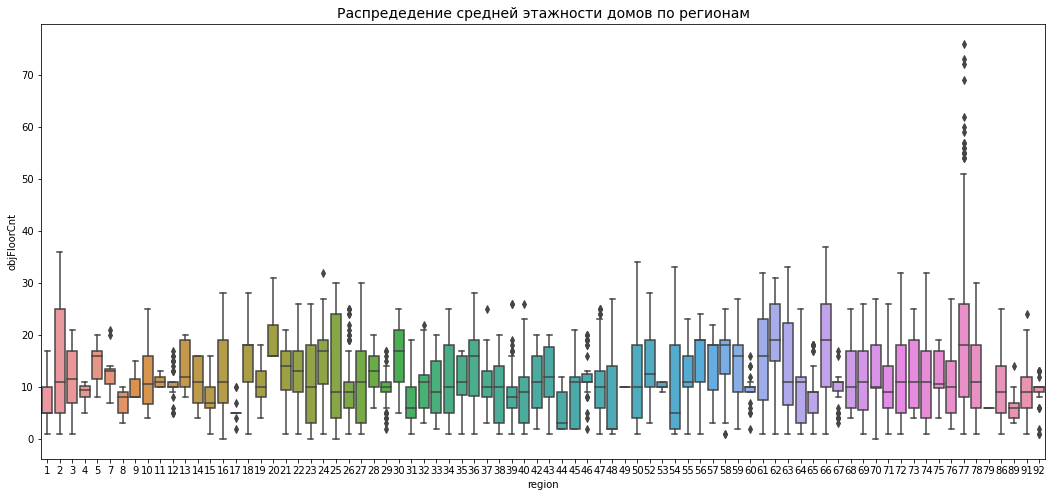

In [34]:
visual_data = Visualizer(dataset.pandas_data)
visual_data.make_boxplot(x='region',
                         y='objFloorCnt',
                         title='Распредедение средней этажности домов по регионам')

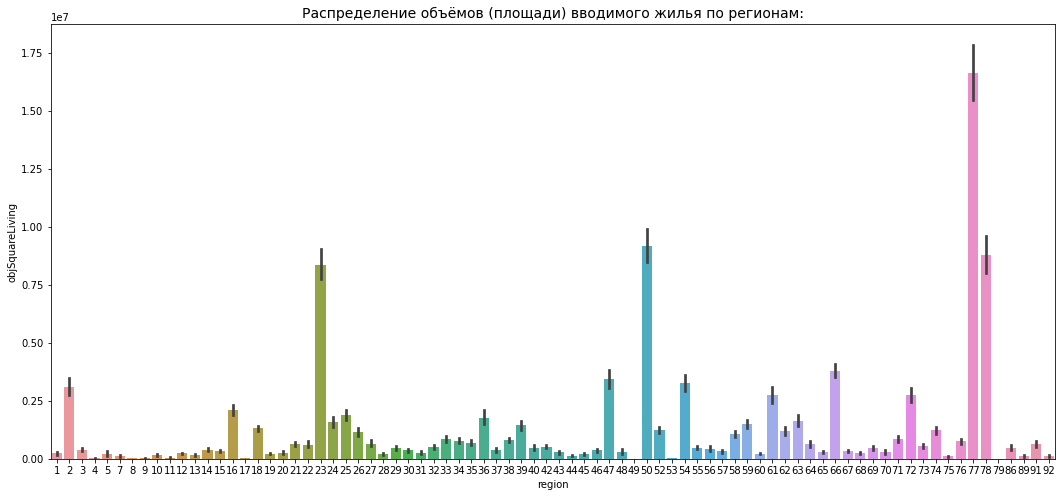

In [35]:
visual_data.make_barplot(x='region',
                         y='objSquareLiving',
                         estimator=sum,
                         title='Распределение объёмов (площади) вводимого жилья по регионам:')